By default, data sent to the OpenAI API will not be used to train or improve OpenAI models.

Quelle: https://openai.com/index/new-embedding-models-and-api-updates/

In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# document loaders
import pypdf
from langchain_community.document_loaders import PyPDFLoader, UnstructuredHTMLLoader # load PDF and HTML files
from langchain_community.document_loaders.csv_loader import CSVLoader # load CSV files

# text splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


import streamlit as st

In [2]:
#pip freeze > requirements.txt

In [3]:
# Loading api keys
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
# google_api_key = os.getenv("GOOGLE_API_KEY")

# Loading files from a directory

In [4]:
# list all files in given directory
def list_files(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# examples usafe for document directory
DOC_PATH = "documents/"
list_of_files = list_files(DOC_PATH) 
print(list_of_files)

["O'Reilly_Praxiseinstieg Large Language Models Einsatz von ChatGPT und anderen LLMs.pdf", "Verlag O'Reilly_Natural Language Processing mit Transformern.pdf"]


In [5]:
def load_document(file_type, file_path):
    """
    Load a document based on the file type. For pdf it loads each page as a separate document.
    You can access the content and metadata of each document after loading using document[0].page_content and document[0].metadata.
    
    Args:
        file_type (str): Type of the file ('csv', 'html', or 'pdf').
        file_path (str): Path to the file.
        
    Returns:
        list: Loaded documents.
    """
    # for html:
    # documents[0].page_content  # Access the content of the first document
    # documents[0].metadata  # Access the metadata of the first document
    if file_type == "csv":
        loader = CSVLoader(file_path=file_path)
    elif file_type == "html":
        loader = UnstructuredHTMLLoader(file_path=file_path)
    elif file_type == "pdf":
        loader = PyPDFLoader(file_path=file_path)
    else:
        raise ValueError("Unsupported file type. Choose from 'csv', 'html', or 'pdf'.")
    return loader.load()

# example usage
first_file = load_document("pdf", DOC_PATH + list_of_files[0])
first_file

[Document(metadata={'producer': 'Acrobat Distiller 11.0 (Windows)', 'creator': 'FrameMaker 12.0.4', 'creationdate': '2024-04-15T11:07:40+02:00', 'author': 'Sinan Ozdemir', 'copyright': 'O’Reilly', 'keywords': '', 'moddate': '2024-11-22T17:23:37+01:00', 'subject': 'Strategien und Best Practices für den Einsatz von ChatGPT und anderen LLMs', 'title': 'Praxiseinstieg Larg Language Models', 'source': "documents/O'Reilly_Praxiseinstieg Large Language Models Einsatz von ChatGPT und anderen LLMs.pdf", 'total_pages': 274, 'page': 0, 'page_label': '1'}, page_content='»Eine erfrischende \nund inspirierende \nRessource. Vollge\xad\npackt mit praktischen \nAnleitungen und \nklaren Erläuterungen, \ndie Ihren Horizont auf \ndiesem spektakulären \nneuen Gebiet \nerweitern.«\n— Pete Huang\nAutor von The Neuron\nPraxiseinstieg Large Language Models\nSinan Ozdemir ist KI-Unternehmer \nund Venture-Capital-Berater \nund hat einen Master in Mathe-\nmatik. Als Gründer und CTO \nvon LoopGenius lotet er mit \

# Splitting into chunks

In [6]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=1000, # for production, use 1000 or more
    chunk_overlap=50, # for production, use 50 or more
)

# Beispiel-Split für Seite aus PDF
sample_content = first_file[16].page_content
sample_text_chunks = splitter.split_text(sample_content)
print(sample_text_chunks)
print([len(chunk) for chunk in sample_text_chunks])

['Aufbau dieses Buchs | 17\nAufbau dieses Buchs\nDas Buch umfasst vier Teile.\nTeil I: Einführung in Large Language Models\nDie Kapitel in Teil I bieten eine Einführung in LLMs (Large Language Models) oder\nmit großen Datenmengen trainierte Sprachmodelle.\n• Kapitel 1: Überblick über Large Language Models\nDieses Kapitel bietet einen breiten Überblick über die Welt von LLMs. Es be-\nhandelt die Grundlagen: Was sind sie, wie funktionieren sie, und warum sind\nsie wichtig? Am Ende dieses Kapitel besitzen Sie solide Grundkenntnisse, um\nden Rest des Buchs zu verstehen.\n• Kapitel 2: Semantische Suche mit LLMs\nAufbauend auf den in Kapitel 1 gelegten Grundlagen, untersucht Kapitel 2, wie\nsich LLMs für eine der einflussreichsten Anwendungen der Sprachmodelle ein-\nsetzen lassen – die semantische Suche. Wir erstellen ein Suchsystem, das die\nBedeutung Ihrer Abfrage versteht und nicht nur Schlüsselwörter vergleicht.\n• Kapitel 3: Erstes Prompt Engineering und ein Chatbot mit ChatGPT', 'Die K

In [7]:
chunks = splitter.split_documents(first_file)
print(f"Number of chunks: {len(chunks)}")
print(f"First chunk: {chunks[0].page_content[:100]}...")  # Print first 100 characters of the first chunk

Number of chunks: 673
First chunk: »Eine erfrischende 
und inspirierende 
Ressource. Vollge­
packt mit praktischen 
Anleitungen und 
kl...


Für das Embedding ist es wichtig, dass nicht nur der Seiteninhalt, sondern auch die Metadaten der Seite gespeichert/übergeben werden. 

# Embedding the chunks
Angabe zu Kosten der Embeddings von OpenAI:
https://openai.com/index/new-embedding-models-and-api-updates/
- text-embedding-3-small will be priced at $0.00002 / 1k tokens.
- text-embedding-3-large will be priced at $0.00013 / 1k tokens.

In [8]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",  # Use a smaller model for faster processing
    openai_api_key=openai_api_key,
)

# Storing the embeddings in a vector database

In [9]:
#import chromadb
persist_dir = "./vector_store"  # Directory to save the vector store
#persistent_client = chromadb.PersistentClient(path=persist_dir)

## saving the embeddings in a vector database

In [10]:
from langchain_chroma import Chroma # ChromaDB vector store

vector_store = Chroma.from_documents(
    collection_name="book-rag",  # Name of the collection in the vector store
    documents=chunks,
    embedding=embedding_model,
    persist_directory=persist_dir, # The vector store is automatically persisted to disk when using the persist_directory parameter.
)

## accessing the vector database

In [11]:
import chromadb
persistent_client = chromadb.PersistentClient(path=persist_dir)

In [12]:
collection = persistent_client.get_or_create_collection(name="book-rag")
collection.peek()  # Check the contents of the collection

{'ids': ['980d8491-849a-4916-afd0-f6481315151d',
  'b7644c28-3f13-498a-9dcd-d0def691dd8f',
  '66a97b10-e31a-4206-ae0b-6d4b3e437aaa',
  'e7f848e6-dcbb-49a9-b34a-b61968a4e5ee',
  '0d18b382-9bc6-43b9-bc5b-bbb516b4fea3',
  'a8a2302d-b610-4000-9f25-9ef35b3a6363',
  '6e29481f-6352-4e9b-af92-ca09242382e3',
  '948f2917-95d2-47b7-a4b5-6d7271659d3a',
  'b3018478-be24-4f4d-b733-eb819b07f654',
  '21d360ac-9a8a-4648-801f-4ffc07f94f3b'],
 'embeddings': array([[-0.04114935,  0.01725916, -0.0259696 , ..., -0.0274252 ,
          0.01073788, -0.01724761],
        [-0.02594493,  0.05223745,  0.02822908, ..., -0.02153802,
          0.00872693,  0.00682761],
        [-0.04504454,  0.01727702,  0.02702175, ..., -0.02781724,
         -0.01397077,  0.01471654],
        ...,
        [-0.02168313,  0.01067083,  0.02736986, ..., -0.01000103,
         -0.0144598 ,  0.01296917],
        [ 0.03294064,  0.03395545,  0.02321879, ...,  0.0131722 ,
          0.00389179,  0.01176162],
        [-0.03101617,  0.03568044, 

In [ ]:
#collection = persistent_client.get_or_create_collection("rag")
# collection.add(ids=["1", "2", "3"], documents=["a", "b", "c"])

# vector_store_from_client = Chroma(
#     client=persistent_client,
#     collection_name="collection_name",
#     embedding_function=embeddings,
# )

In [ ]:
# adding documets to the vector store
# vector_store.add_documents(documents=_new_chunks)

In [ ]:
# You can also update existing documents by using the update_documents function.
# vector_store.update_documents(document_ids=["1", "2"], documents=["new content 1", "new content 2"])

# or delete documents
# vector_store.delete(document_ids=["1", "2"])

## Query vector store
Once your vector store has been created and the relevant documents have been added you will most likely wish to query it during the running of your chain or agent.


In [13]:
# Query directly - similarity search
results = vector_store.similarity_search_with_score(
    "Was ist der Inhalt des Dokuments?",
    k=2,
    # filter={"source": "tweet"}  # Optional filter to narrow down results based on metadata
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=0.918956] Dokument zurückgeben.
Die Komponenten
Sehen wir uns nun die einzelnen Komponenten genauer an, um zu verstehen, welche
Entscheidungen wir treffen und welche Überlegungen wir dabei anstellen müssen.
Eingebettete
Dokumentespeichern
Datenbank
Dokumente–
möglicherweise
chunked
Text-Embedder
Datenbank
KandidatenabrufenAbfrage/Frage
Abfrageeinbetten
undmitDokumenten
inDatenbank
vergleichen
Optionalneu
einstufen
Listemit
Ergebnissen [{'page_label': '57', 'title': 'Praxiseinstieg Larg Language Models', 'moddate': '2024-11-22T17:23:37+01:00', 'author': 'Sinan Ozdemir', 'keywords': '', 'total_pages': 274, 'subject': 'Strategien und Best Practices für den Einsatz von ChatGPT und anderen LLMs', 'page': 56, 'creationdate': '2024-04-15T11:07:40+02:00', 'copyright': 'O’Reilly', 'source': "documents/O'Reilly_Praxiseinstieg Large Language Models Einsatz von ChatGPT und anderen LLMs.pdf", 'creator': 'FrameMaker 12.0.4', 'producer': 'Acrobat Distiller 11.0 (Windows)'}]
* [SIM=0.936975] 8 

In [ ]:
# query using persistent client
text = "Was ist der Inhalt des Dokuments?"

results = collection.query(
    query_embeddings=embedding_model.embed_query(text),
    n_results=2
)
results

{'ids': [['aeff6760-b1bb-4b13-81ab-52293b77aa71',
   'ce9a7971-df76-47ae-8628-8c0ac70f28bb']],
 'embeddings': None,
 'documents': [['Dokument zurückgeben.\nDie Komponenten\nSehen wir uns nun die einzelnen Komponenten genauer an, um zu verstehen, welche\nEntscheidungen wir treffen und welche Überlegungen wir dabei anstellen müssen.\nEingebettete\nDokumentespeichern\nDatenbank\nDokumente–\nmöglicherweise\nchunked\nText-Embedder\nDatenbank\nKandidatenabrufenAbfrage/Frage\nAbfrageeinbetten\nundmitDokumenten\ninDatenbank\nvergleichen\nOptionalneu\neinstufen\nListemit\nErgebnissen',
   '8 | Inhalt\nDie Komponenten  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  57\nEngines für Text-Embeddings  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  58\nChunking von Dokumenten  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  62\nVektordatenbanken  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  68\nPinecone

# LLM
simple workflow:
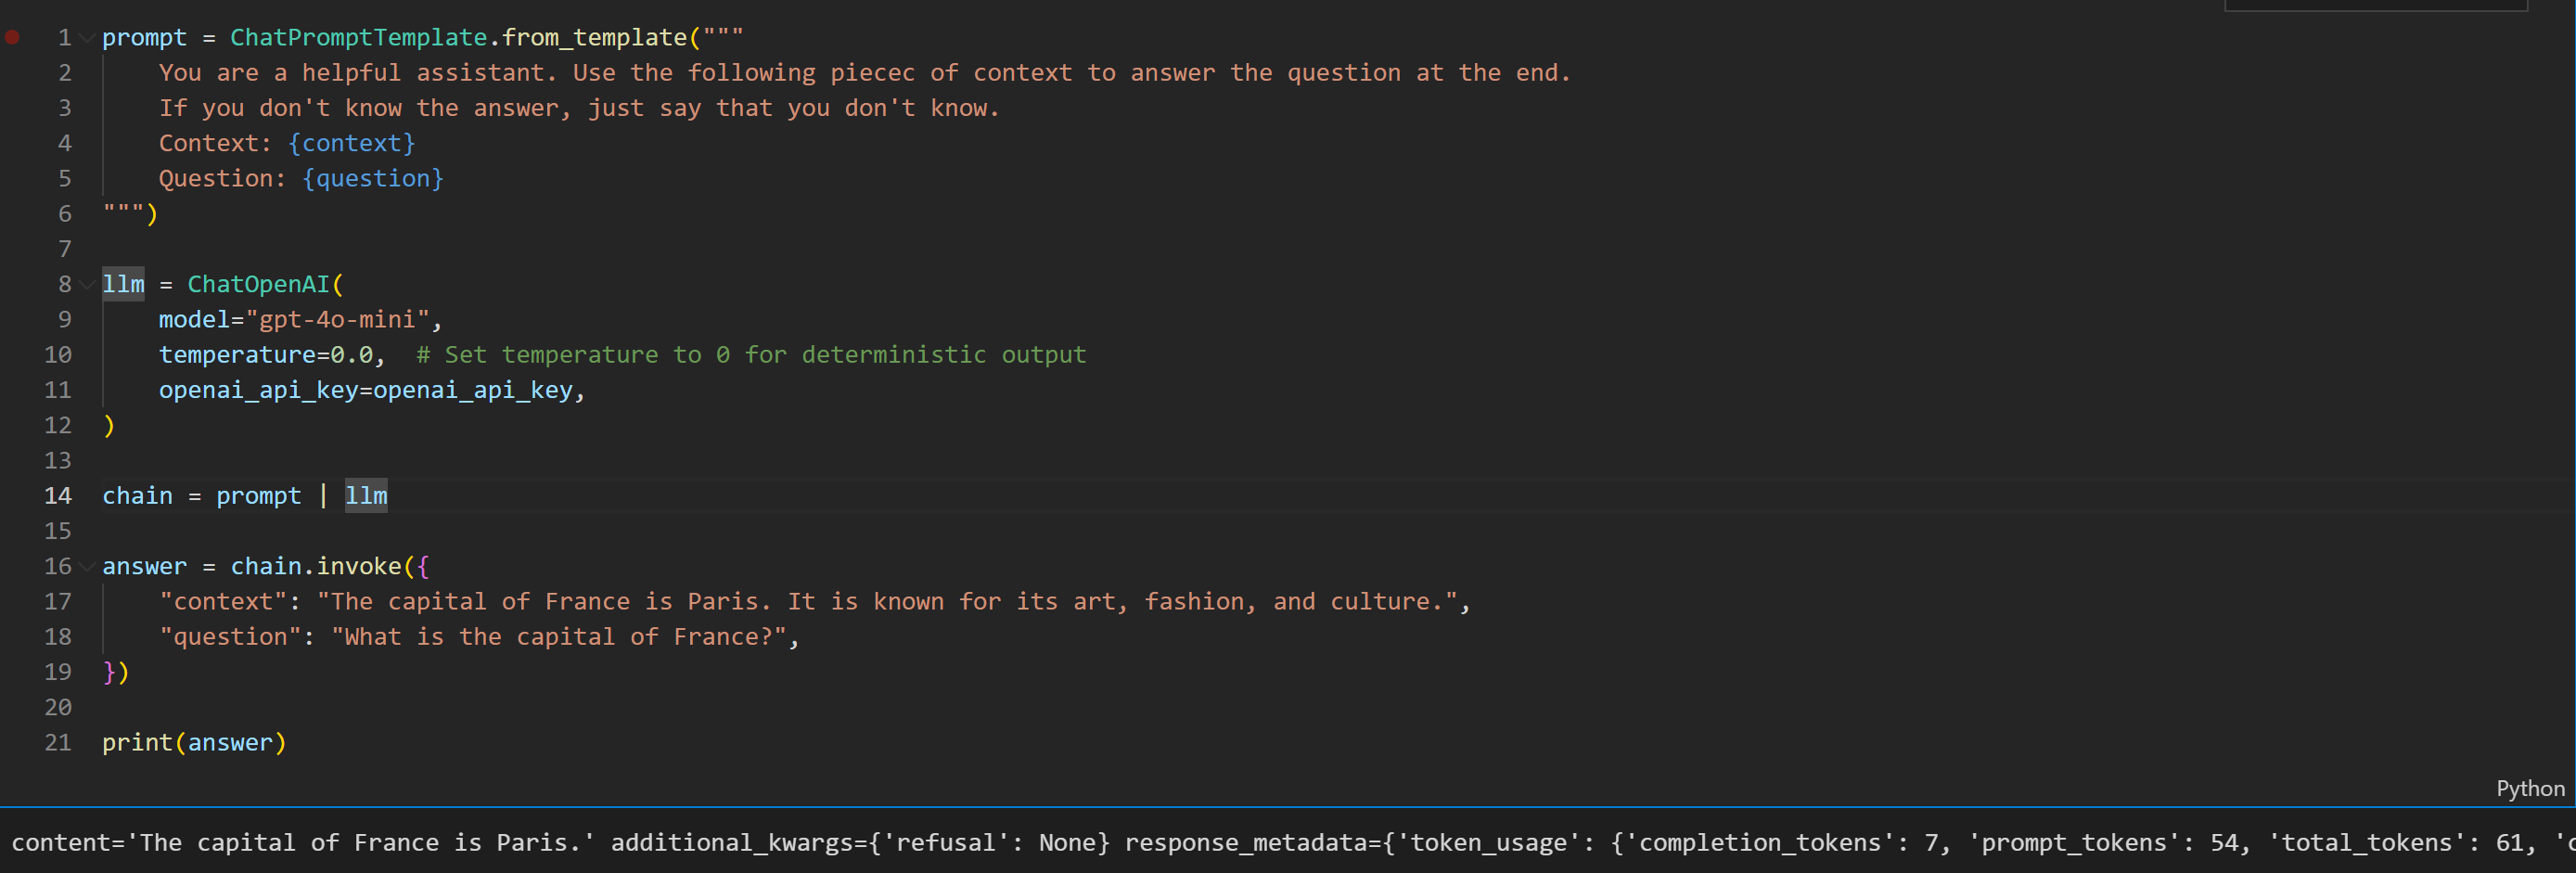

In [ ]:
prompt = ChatPromptTemplate.from_template("""
    You are a helpful assistant. Use the following piece of context to answer the question at the end. 
    If you don't know the answer, just say that you don't know.
    Context: {context}
    Question: {question}    
""")

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,  # Set temperature to 0 for deterministic output
    openai_api_key=openai_api_key,
)

# Instantiating a retriever

In [22]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}  # Retrieve the top 3 most similar documents
)

# Building LCEL retireval chain

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [27]:
answer = chain.invoke("Wie viele Teile hat das Buch und was ist der Titel des ersten Teils?")
print(answer)  # Print the answer to the question

content='Das Buch umfasst vier Teile. Der Titel des ersten Teils ist "Einführung in Large Language Models".' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 620, 'total_tokens': 641, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BeFZinV28MTuMYAV7Orfoh8Fhefb4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--0a12c649-4a11-4353-90a6-b08863932d54-0' usage_metadata={'input_tokens': 620, 'output_tokens': 21, 'total_tokens': 641, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


# RAG-System

In [ ]:
from langchain.chains import create_history_aware_retriever
history_aware_retriever = create_history_aware_retriever(
    retriever=retriever,
    llm=llm,
    history_length=3,  # Number of previous interactions to consider
)